In [41]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [6]:
%reload_ext autoreload
%autoreload 2

import os
import tensorflow as tf
from matplotlib import pyplot as plt

from models import *
from create_data import *
from utils import *

# Joanna Broniarek - Neural Networks Final Project 2020

-------

# DCGAN-for-MRI-images
Inspiration for this project was this paper: http://www.nlab.ci.i.u-tokyo.ac.jp/pdf/isbi2018.pdf

The idea was to implement and train a **DCGAN model** on 3D MRI T1-weighted images from the BRATS 2019 dataset.

## 1. Example of the ORIGINAL  images used for training the GANs:

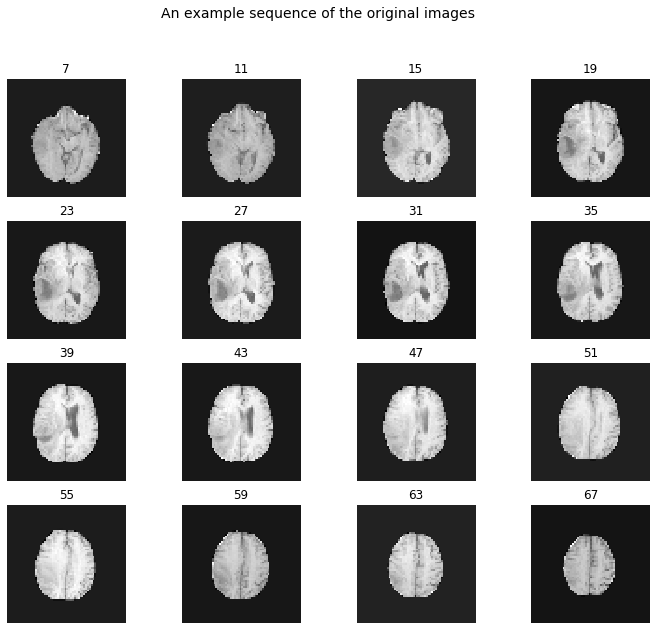

In [3]:
example_img = load_img('data/BraTS19_TCIA01_401_1_t1.nii.gz')
plot_image_seq(example_img)

## 2. Preprocessing

* I selected the slices from 50 to 125 among the whole 155 slices to omit initial/final ones, since they convey a negligible amount of useful information and could affect the training.

* The images are resized to 64 × 64 from 240 x 240

* I normalised the images to zero mean/unit std dev

## 3. TFRecords
* For most deep learning problems on image volumes, the database of training examples is too large to fit into memory. The TFRecords format allows to serialise training examples and store them on disk with quick write access. (i.e. parallel data reads)
* TFRecords are fast means of accessing files from disk, but require to store yet another copy of the entire training database. However,  Iused the Google Cloud Platform resources.

## 4. Models
* batch size = 16 (due to GPU limitations)
* kernel of size 4
* padding = 'same'
* strides = (1, 2, 2)

### Discriminator
* four 3DConv layers
* four Dropout to avoid overconfidence
* Leaky Relu act.
* one Dense layer

* ADAM optimizer with initial lr=5e-5

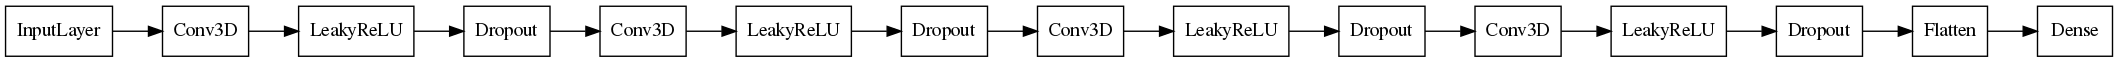

In [4]:
discriminator=discriminator3d()
tf.keras.utils.plot_model(discriminator, show_shapes = False, rankdir='LR', dpi=100, show_layer_names=False)

### Generator
* one Dense layer + Elu act.
* four Conv3DTranspose layers + ReLU act.
* ADAM optimizer with initial lr=5e-4

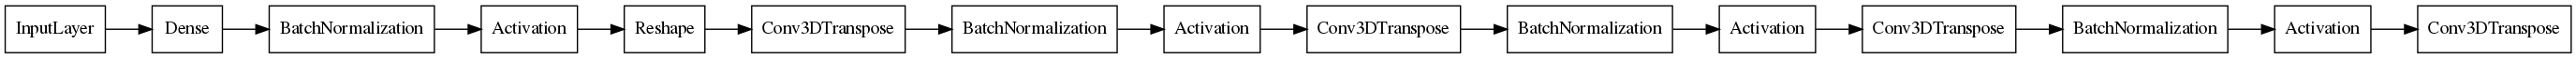

In [5]:
generator = generator3d()
tf.keras.utils.plot_model(generator, show_shapes = False, rankdir='LR', dpi=100, show_layer_names=False)

## 5. Losses

### Generator Loss

Generator loss measures how well it was able to cheat on the discriminator.

* **Cross Entropy Loss**.

* **Label Smoothing** - Instead of 0 for a negative class it assigns a random integer in range (0, 0.3)

-------------

### Discriminator Loss

Discriminator loss measures how well the discriminator was able to distinguish real and fake images. 

* **Cross Entropy Loss**.
* **Added noise to labels** +  **Label Smoothing** - Instead of 1 for a positive class it assigns a random integer in range (0.7, 1)

In [74]:
%load_ext tensorboard
%tensorboard --logdir logs/2020-05-04_06:40:29/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9886), started 5:09:47 ago. (Use '!kill 9886' to kill it.)

## 6. Training : Sample run for 100 epochs

<img src="docs/mri.gif" width="600" height="600">

## 7. Generator - example of the synthetic sequence of images

In [8]:
save_dir_path = 'logs/2020-05-04_06:40:29/'
checkpoint_dir = save_dir_path
checkpoint_prefix = os.path.join("training_checkpoints", "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator)

manager = tf.train.CheckpointManager(checkpoint,
                                  directory=checkpoint_dir,
                                  max_to_keep = 10,
                                  checkpoint_name=checkpoint_prefix)

status = checkpoint.restore(manager.latest_checkpoint)

noise_size = 100

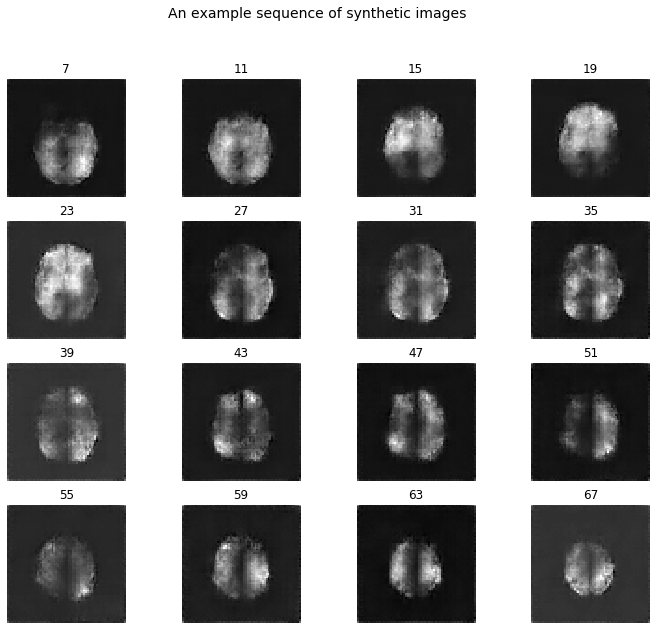

In [40]:
np.random.seed(8)
test_noise = np.random.uniform(-1, 1, size=(1, noise_size))
generate_image(generator, test_noise, show=True)

## 8. Problems & Possible improvements

### Problems encountered while training
* Discriminator Loss was decreasing to zero values after few epochs
* Exploding Losses
* Memory issues (tfRecords, BufferSize)

### Used tricks to overcome the problems
* Batch Normalization
* Weight Initializer from Truncated Normal distribution
* tuning of the initial learning rates
* Decaying learning rates (ExponentialDecay)
* trying different Activation functions

### Ideas of possible further improvements: 
1. More training epochs
2. Add some spatial augmentations i.e.:
    * Random deformations, (e.g. for mimicking differences in organ shape)
    * Rotations along axes, etc.